In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sn
import math
import json
import time
from sklearn.model_selection import train_test_split
import joblib
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [2]:
data=pd.read_csv("/content/ratings_Electronics (1).csv",names=['userId','productId','Rating','timestamp'])

In [3]:
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
data.shape

(7824482, 4)

In [5]:
data.columns

Index(['userId', 'productId', 'Rating', 'timestamp'], dtype='object')

In [6]:
data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
data.describe()['Rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
print("Minimum rating: %d"%(data.Rating.min()))
print("Maximum rating: %d"%(data.Rating.max()))

Minimum rating: 1
Maximum rating: 5


In [10]:
print(data.isnull().sum())

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [11]:
print(data.Rating.isnull().sum())

0


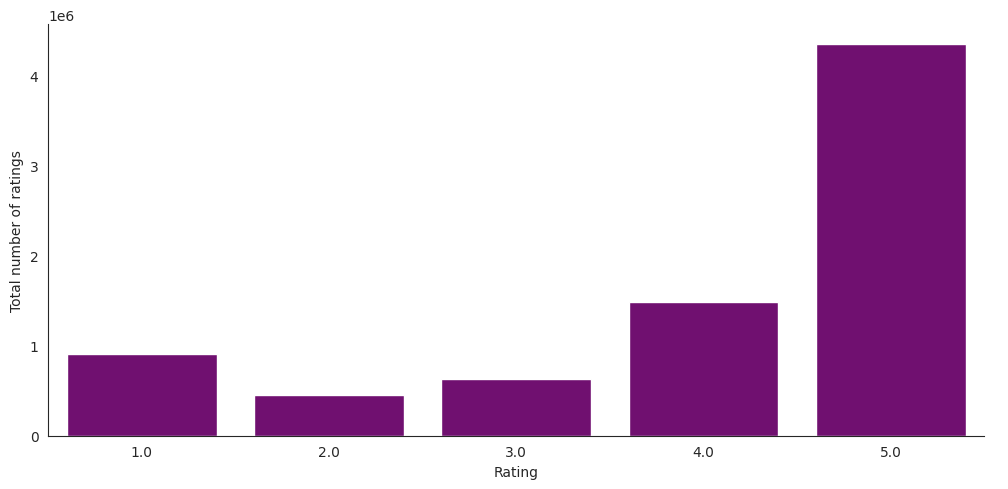

In [12]:
with sn.axes_style('white'):
    pt=sn.catplot(x="Rating",data=data,aspect=2.0,kind='count',color='purple')
    pt.set_ylabels("Total number of ratings")

In [13]:
data.drop(['timestamp'],axis=1,inplace=True)

In [14]:
data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [15]:
no_products_rated_per_user=data.groupby(by="userId")['Rating'].count().sort_values(ascending=False)

In [16]:
print(no_products_rated_per_user.head(),"\n --------------------------")
print(no_products_rated_per_user.describe())

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64 
 --------------------------
count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64


In [17]:
print(f"Products rated more than 50 per user: {sum(no_products_rated_per_user>=50)}")  # Number of products that are rated more than 50 user

Products rated more than 50 per user: 1540


# Popularity Based Filtering

In [18]:
# A new dataframe contains users who has given 50 or more ratings

In [19]:
df=data.groupby(by='productId').filter(lambda x:x['Rating'].count()>=50)

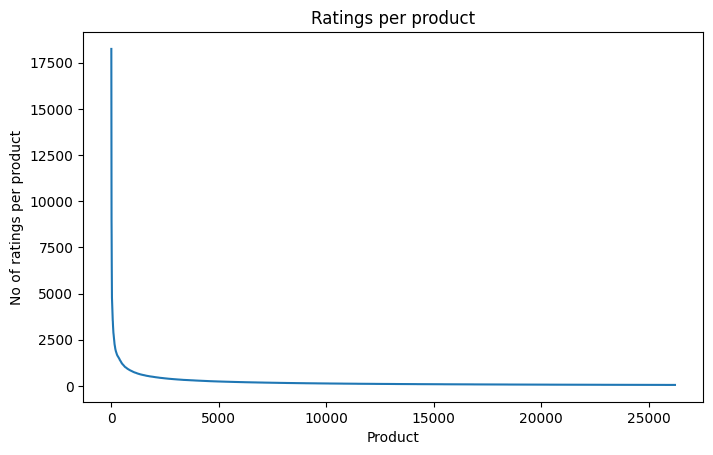

In [20]:
no_products_rated_user=df.groupby(by="productId")['Rating'].count().sort_values(ascending=False)
fig=plt.figure(figsize=plt.figaspect(0.6))
ax=plt.gca()
plt.plot(no_products_rated_user.values)
plt.title('Ratings per product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
# ax.set_xticklabels([])
plt.show()

In [21]:
# Average rating per product

df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [22]:
df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

In [23]:
# Total no of rating for product

df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [24]:
ratings_mean_count=pd.DataFrame(df.groupby('productId')['Rating'].mean())

In [25]:
ratings_mean_count['rating_count']=pd.DataFrame(df.groupby('productId')['Rating'].count())

In [26]:
ratings_mean_count.head()

,Rating,rating_count
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


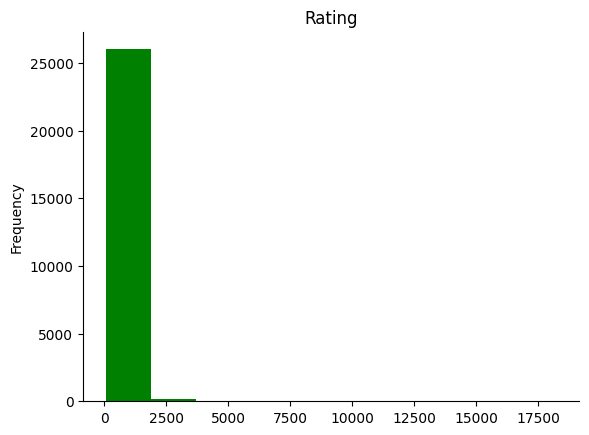

In [27]:
# @title Rating

ratings_mean_count['rating_count'].plot(kind='hist', bins=10, title='Rating',color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
ratings_mean_count['Rating'].max()

4.980392156862745

<Axes: >

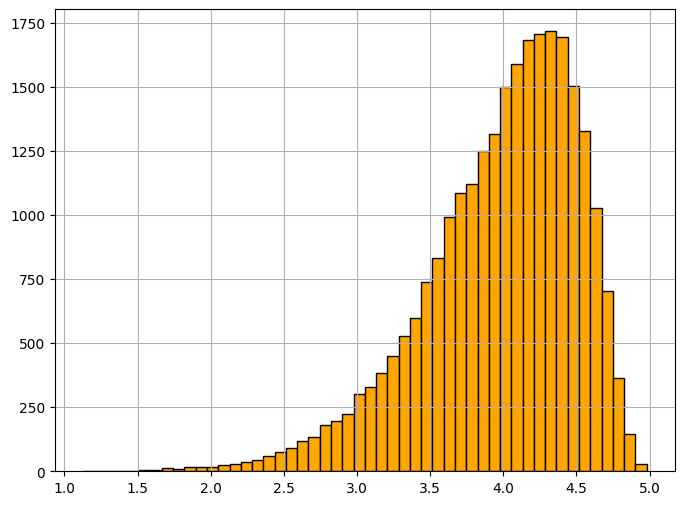

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50,color="Orange")

<Axes: xlabel='productId'>

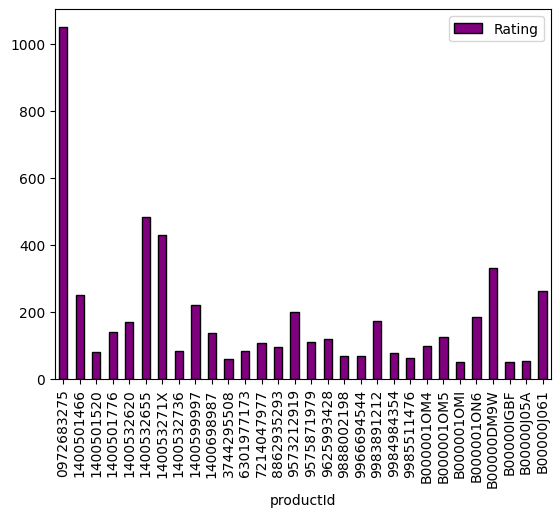

In [30]:
popular_products=pd.DataFrame(df.groupby('productId')['Rating'].count())
popular_products.sort_values('Rating',ascending=False)
popular_products.head(30).plot(kind='bar',color="purple")

# Collaborative Filtering

In [31]:
!pip install surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [32]:
# Reading the dataset

read=Reader(rating_scale=(1,5))
data0=Dataset.load_from_df(df,read)

In [33]:
train,test=train_test_split(data0,test_size=0.3,random_state=10)

In [ ]:
# Using the user_based True/False to switch between user-based or item-based collaborative filtering

algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(train)

In [ ]:
# Running the test model against the test data

tst_prd=algo.test(test)

In [ ]:
tst_prd

In [ ]:
accuracy.rmse(tst_prd,verbose=True)

# MODEL BASED COLLABORATIVE FILTERING

In [ ]:
df=df.head(10000)
rm0=df.pivot_table(values='Rating',index='userId',columns='productId',fill_value=0)

In [ ]:
rm0.head(10)

In [ ]:
rm=rm0.T
rm.shape

In [ ]:
from sklearn.decomposition import TruncatedSVD
SVD=TruncatedSVD(n_components=10)
decomposed_matrix=SVD.fit_transform(rm)
decomposed_matrix.shape

In [ ]:
corr_matrix=np.corrcoef(decomposed_matrix)
corr_matrix.shape

In [ ]:
rm.index[8]

In [ ]:
i="1400599997"
p_name=list(rm.index)
p_id=p_name.index(i)
p_id

In [ ]:
corr_p_id=corr_matrix[p_id]
corr_p_id.shape

10 high recommended products

In [ ]:
recommend=list(rm.index[corr_p_id>0.65])
recommend.remove(i)     # Removed the product bought by the customer
recommend[0:10]